# Multiple Inputs Binary Classification Modeling 
## A Machine Learning Case Study 
## Fitting and Assessing the Performance of Multiple Classification Models
This machine learning project is focused on binary classification using multiple input features. It aims to classify data into two distinct categories based on various input attributes. Multiple input binary classification modeling is a machine learning approach where a model is trained to classify data into two distinct categories (binary classification) based on multiple input features. In this context, "multiple inputs" means that the model uses more than one feature or attribute from the data to make a prediction.

Reference: "Fitting and assessing the performance of multiple CLASSIFICATION models" by Dr. Dmitriy Babichenko

Dataset: Binary Classification.csv 

Source: 
University of Pittsburg SOI"

## Import Modules
Import data manipulation and machine learning modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
# Suppress future warnings
import warnings
warnings.filterwarnings("ignore")

## Read in the data

In [3]:
df = pd.read_csv('sample_dataset.csv')
df.head()

,input_1,input_2,input_3,input_4,input_5,output
0,1.125708,0.318240,-0.562729,0.721059,b,0
1,0.038214,1.525541,-1.492170,-1.190414,b,0
2,-0.132998,-0.072113,1.505507,0.026712,b,1
3,1.928824,-0.976429,1.165456,1.522892,b,0
4,-0.386148,0.802894,-0.094305,-0.657699,b,0


In [4]:
# Preview the dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   input_1  300 non-null    float64
 1   input_2  300 non-null    float64
 2   input_3  300 non-null    float64
 3   input_4  300 non-null    float64
 4   input_5  300 non-null    object 
 5   output   300 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 14.2+ KB


In [5]:
# Check dataset for missings
df.isna().sum()

input_1    0
input_2    0
input_3    0
input_4    0
input_5    0
output     0
dtype: int64

In [6]:
# Check the number of unique values for each variable
df.nunique()

input_1    300
input_2    300
input_3    300
input_4    300
input_5      3
output       2
dtype: int64

In [7]:
# Look at the data types
df.dtypes

input_1    float64
input_2    float64
input_3    float64
input_4    float64
input_5     object
output       int64
dtype: object

There are no missing data points. We have 4 continuous variables and 2 categorical variables, one of which is an integer with two unique values. Since we will be classifying the output variable, let's check the counts and proportions of the unique values.

In [8]:
# Check output count
df.output.value_counts()

output
0    198
1    102
Name: count, dtype: int64

In [9]:
# Check the output proportion
df.output.value_counts(normalize=True)

output
0    0.66
1    0.34
Name: proportion, dtype: float64

The output consists of two unique values, 0 and 1, represented as binary indicators. Output value 1 is the Event, which occurs 34% of the time, and output value 0 is the Non-Event, which occurs 66% of the time. By default, the Event occurs less frequently than the Non-Event.

In [10]:
# Verify the observed proportion of the event and non-event
print('Event:', df.output.mean() * 100,'%' )
print('Non Event:', (1 - df.output.mean()) * 100,'%')

Event: 34.0 %
Non Event: 65.99999999999999 %


Why is this important? The reason why this is so critcally important is because when we calculate the model accuracy we want to see if it is better than the observed proportion of the event.

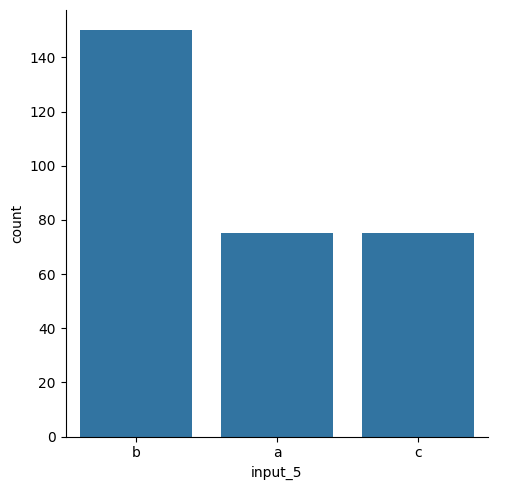

In [11]:
# Explore the categorical input using a bar chart
sns.catplot(x='input_5', data=df, kind='count')
plt.show()

Notice `b` have a higher frequency that the values `a` and `c`. But we don't have a very large disproportionate difference from the two.

Let's check standard divaition, minimum and maximum inputs bounds of the continuous input. This is important because we want to know the data bound that we will use to fit the model.

In [12]:
# Summarize the dataset 
df.describe()

,input_1,input_2,input_3,input_4,output
count,300.000000,300.000000,300.000000,300.000000,300.0000
mean,-0.000849,0.000261,0.002302,0.001372,0.3400
std,0.998805,1.000864,1.004086,1.001563,0.4745
min,-2.913116,-3.008946,-2.783621,-2.864881,0.0000
25%,-0.673919,-0.671703,-0.673862,-0.673474,0.0000
50%,0.000468,-0.001799,0.001278,0.002178,0.0000
75%,0.673103,0.671835,0.674558,0.670999,1.0000
max,2.783826,3.120873,3.497789,3.128220,1.0000


Here we can see that the std (scale) of the features are non negative and closer to 1 as such we don't have to worry about standardzing. Next let's fit the logistics model.

Let's define a function that will allow us to fit and calculate the training set performance for any formula.

In [13]:
# Funtion to fit and access logistic model
def fit_access_logit( model_name, a_formula, training_data, threshold ):
    fit_model = smf.logit( formula = a_formula, data = training_data).fit() # fit any model
    
    # Make a hard copy of the training set dataset
    training_set_copy = training_data.copy() 
    
    # Calculate training set predictive probability
    training_set_copy['pred_probability'] = fit_model.predict( training_data )
     

    # Convert predictive probability into classification
    training_set_copy['pred_class'] = np.where( training_set_copy.pred_probability > threshold, 1, 0 ) 

    # Apply the confusion matrix function to pull out events from the output and convert to a 2D array
    TN, FP, FN, TP, = confusion_matrix( training_set_copy.output.to_numpy(), training_set_copy.pred_class.to_numpy() ).ravel()

    # Calculate the Prediction Accuracy
    Accuracy = (TN + TP) / (TN + FP + FN + TP)

    # Calculate the Prediction Sensitivity
    Sensitivity = (TP) / (TP + FN)

    # Calculate the Specificity
    Specificity = (TN / (TN + FP))

    # Calculate the False Positive Rate (FPR)
    FPR = 1 - Specificity

    # Examine the behavior for any threshold value and convert ROC curve to quantitative metric
    ROC_AUC = roc_auc_score(training_set_copy.output.to_numpy(), training_set_copy.pred_probability.to_numpy() )

    # Store the result in a dictionary
    result_dict = {'model_name': model_name,
                  'model_formula': a_formula,
                  'num_coefficients': len(fit_model.params),
                  'threshold': threshold,
                  'Accuracy': Accuracy,
                  'Sensitivity': Sensitivity,
                  'Specificity': Specificity,
                  'FPR': FPR,
                  'ROC_AUC': ROC_AUC}
    # Return the dictionary as dataframe and set the index because each value is a scalar value
    return pd.DataFrame( result_dict, index=[0] )
                  

In [14]:
# Test function with a simple linear model
fit_access_logit(0, 'output ~ 1', training_data=df, threshold=0.5)

Optimization terminated successfully.
         Current function value: 0.641035
         Iterations 4


,model_name,model_formula,num_coefficients,threshold,Accuracy,Sensitivity,Specificity,FPR,ROC_AUC
0,0,output ~ 1,1,0.5,0.66,0.0,1.0,0.0,0.5


Next let's create a list of models with different formulas that we can use to fit. 

In [15]:
model_list = ['output ~ 1',
                'output ~ input_5',
                'output ~ input_1 + input_2 + input_3 + input_4',
                'output ~ input_1 + input_2 + input_3 + input_4 + input_5',
                'output ~ input_5 * (input_1 + input_2 + input_3 + input_4)',
                'output ~ (input_1 + input_2 + input_3 + input_4) ** 2',
                'output ~ input_1 + input_2 + input_3 + input_4 + np.power(input_1,2) + np.power(input_2,2) + np.power(input_3,2) + np.power(input_4,2)',
                'output ~ input_5 + input_1 + input_2 + input_3 + input_4 + np.power(input_1,2) + np.power(input_2,2) + np.power(input_3,2) + np.power(input_4,2)',
                'output ~ input_5 * (input_1 + input_2 + input_3 + input_4 + np.power(input_1,2) + np.power(input_2,2) + np.power(input_3,2) + np.power(input_4,2))',
                'output ~ input_5 + ( (input_1 + input_2 + input_3 + input_4)**2 + np.power(input_1,2) + np.power(input_2,2) + np.power(input_3,2) + np.power(input_4,2))',
                'output ~ input_5 * ( (input_1 + input_2 + input_3 + input_4)**2 + np.power(input_1,2) + np.power(input_2,2) + np.power(input_3,2) + np.power(input_4,2))',
                'output ~ input_5 + (input_1 + input_2 + input_3 + input_4)**3',
                'output ~ input_5 + (input_1 + input_2 + input_3 + input_4)**4',
                'output ~ (input_1 + input_2 + input_3 + input_4 + input_5)**3',
                'output ~ (input_1 + input_2 + input_3 + input_4 + input_5)**4',
                'output ~ input_5 * ( (input_1 + input_2 + input_3 + input_4)**3 + np.power(input_1,2) + np.power(input_2,2) + np.power(input_3,2) + np.power(input_4,2) + np.power(input_1,3) + np.power(input_2,3) + np.power(input_3,3) + np.power(input_4,3) )',
                'output ~ input_5 * ( (input_1 + input_2 + input_3 + input_4)**3 + np.power(input_1,2) + np.power(input_2,2) + np.power(input_3,2) + np.power(input_4,2) + np.power(input_1,3) + np.power(input_2,3) + np.power(input_3,3) + np.power(input_4,3) + np.power(input_1,4) + np.power(input_2,4) + np.power(input_3,4) + np.power(input_4,4) )']

Now, every element in this list defines a model. To use any model, all you have to do is reference the list position. For example, let's reference the eleventh element.

In [16]:
# Display the 11th model in the list
model_list[11]

'output ~ input_5 + (input_1 + input_2 + input_3 + input_4)**3'

Now let's use a for loop to iterate over all model formulas in the list and apply the fit and access logistic fuinction to each one. Storing the result in to a resukts variable

In [17]:
# Initialize result list
result_list = []

# Iterate over model list and apply the fit function
for m in range(len(model_list)):
    result_list.append(fit_access_logit( m, model_list[m], training_data = df, threshold=0.5 ))
    

Optimization terminated successfully.
         Current function value: 0.641035
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634259
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594506
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588229
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569593
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.587858
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.513238
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.503664
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.481047
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.499744
  

All the models in our list have been successfully fitted, and the results have been displayed. Now, we get a fit for each element in our model list. Now, let's verify how many models are fitted with all the set parameters that I defined above in the dictionary.

In [18]:
# Check the number of models fitted
len(result_list)

17

Now we can select the model result for each element to view or combine all the result into a single dataframe

In [19]:
# show a single fitted model result
result_list[3]

,model_name,model_formula,num_coefficients,threshold,Accuracy,Sensitivity,Specificity,FPR,ROC_AUC
0,3,output ~ input_1 + input_2 + input_3 + input_4...,7,0.5,0.66,0.264706,0.863636,0.136364,0.70098


In [20]:
# COntatenate all models result into a single dataframe
model_results_df = pd.concat(result_list, ignore_index=True)

In [21]:
# Show model result dataframe
model_results_df

,model_name,model_formula,num_coefficients,threshold,Accuracy,Sensitivity,Specificity,FPR,ROC_AUC
0,0,output ~ 1,1,0.5,0.660000,0.000000,1.000000,0.000000,0.500000
1,1,output ~ input_5,3,0.5,0.660000,0.000000,1.000000,0.000000,0.564988
2,2,output ~ input_1 + input_2 + input_3 + input_4,5,0.5,0.626667,0.205882,0.843434,0.156566,0.693207
3,3,output ~ input_1 + input_2 + input_3 + input_4...,7,0.5,0.660000,0.264706,0.863636,0.136364,0.700980
4,4,output ~ input_5 * (input_1 + input_2 + input_...,15,0.5,0.693333,0.274510,0.909091,0.090909,0.731779
5,5,output ~ (input_1 + input_2 + input_3 + input_...,11,0.5,0.653333,0.245098,0.863636,0.136364,0.700634
6,6,output ~ input_1 + input_2 + input_3 + input_4...,9,0.5,0.740000,0.588235,0.818182,0.181818,0.788622
7,7,output ~ input_5 + input_1 + input_2 + input_3...,11,0.5,0.723333,0.500000,0.838384,0.161616,0.800158
8,8,output ~ input_5 * (input_1 + input_2 + input_...,27,0.5,0.766667,0.558824,0.873737,0.126263,0.822787
9,9,output ~ input_5 + ( (input_1 + input_2 + inpu...,17,0.5,0.733333,0.519608,0.843434,0.156566,0.801347


As you can see, we now have different models with many performance metrics, which we can use to extract the model with the best training data. For example, owing to the nature of the modeling application you are working on, we can sort the models by accuracy, sensitivity, specificity, ROC_AUC, etc, to find which model is the best. Let's sort by Accuracy first. 

In [22]:
 # Sort model by accuracy in descending order
model_results_df.sort_values(by=['Accuracy'], ascending=False)

,model_name,model_formula,num_coefficients,threshold,Accuracy,Sensitivity,Specificity,FPR,ROC_AUC
16,16,output ~ input_5 * ( (input_1 + input_2 + inpu...,81,0.5,0.813333,0.715686,0.863636,0.136364,0.916815
15,15,output ~ input_5 * ( (input_1 + input_2 + inpu...,69,0.5,0.806667,0.686275,0.868687,0.131313,0.888146
8,8,output ~ input_5 * (input_1 + input_2 + input_...,27,0.5,0.766667,0.558824,0.873737,0.126263,0.822787
10,10,output ~ input_5 * ( (input_1 + input_2 + inpu...,45,0.5,0.760000,0.588235,0.848485,0.151515,0.851951
6,6,output ~ input_1 + input_2 + input_3 + input_4...,9,0.5,0.740000,0.588235,0.818182,0.181818,0.788622
14,14,output ~ (input_1 + input_2 + input_3 + input_...,46,0.5,0.736667,0.421569,0.898990,0.101010,0.794959
9,9,output ~ input_5 + ( (input_1 + input_2 + inpu...,17,0.5,0.733333,0.519608,0.843434,0.156566,0.801347
13,13,output ~ (input_1 + input_2 + input_3 + input_...,37,0.5,0.726667,0.382353,0.904040,0.095960,0.763171
7,7,output ~ input_5 + input_1 + input_2 + input_3...,11,0.5,0.723333,0.500000,0.838384,0.161616,0.800158
12,12,output ~ input_5 + (input_1 + input_2 + input_...,18,0.5,0.700000,0.343137,0.883838,0.116162,0.724896


Here, the model at the top of the list is the one with the highest accuracy. You can see it has the most coefficients and the most complex formula. Its training set accuracy is 81%. However, what if I sort by ROC_AUC? Accuracy requires one threshold, while ROC_AUC tries out several thresholds defined in its function. Let's see that...

In [23]:
# Sort model by accuracy in descending order
model_results_df.sort_values(by=['ROC_AUC'], ascending=False)

,model_name,model_formula,num_coefficients,threshold,Accuracy,Sensitivity,Specificity,FPR,ROC_AUC
16,16,output ~ input_5 * ( (input_1 + input_2 + inpu...,81,0.5,0.813333,0.715686,0.863636,0.136364,0.916815
15,15,output ~ input_5 * ( (input_1 + input_2 + inpu...,69,0.5,0.806667,0.686275,0.868687,0.131313,0.888146
10,10,output ~ input_5 * ( (input_1 + input_2 + inpu...,45,0.5,0.760000,0.588235,0.848485,0.151515,0.851951
8,8,output ~ input_5 * (input_1 + input_2 + input_...,27,0.5,0.766667,0.558824,0.873737,0.126263,0.822787
9,9,output ~ input_5 + ( (input_1 + input_2 + inpu...,17,0.5,0.733333,0.519608,0.843434,0.156566,0.801347
7,7,output ~ input_5 + input_1 + input_2 + input_3...,11,0.5,0.723333,0.500000,0.838384,0.161616,0.800158
14,14,output ~ (input_1 + input_2 + input_3 + input_...,46,0.5,0.736667,0.421569,0.898990,0.101010,0.794959
6,6,output ~ input_1 + input_2 + input_3 + input_4...,9,0.5,0.740000,0.588235,0.818182,0.181818,0.788622
13,13,output ~ (input_1 + input_2 + input_3 + input_...,37,0.5,0.726667,0.382353,0.904040,0.095960,0.763171
4,4,output ~ input_5 * (input_1 + input_2 + input_...,15,0.5,0.693333,0.274510,0.909091,0.090909,0.731779


Sorting by ROC_AUC still tells me that our best-fitted model is `model number 16` with 81% accuracy and 81 coefficients. Essentially, the training set performance is getting better as the number of coefficients increases. As such we can confirm that with a scatter plot.

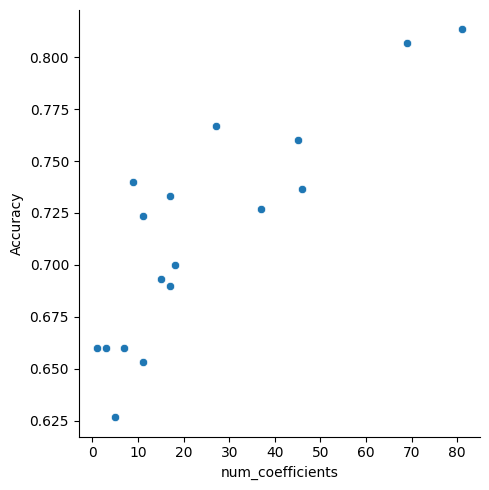

In [24]:
# Plot selected training set model using a scatter plot
sns.relplot(data = model_results_df, x='num_coefficients', y='Accuracy')
plt.show()

You can see as the number of coefficient is increasing the accuracy is increasing. Let check with ROC_AUC

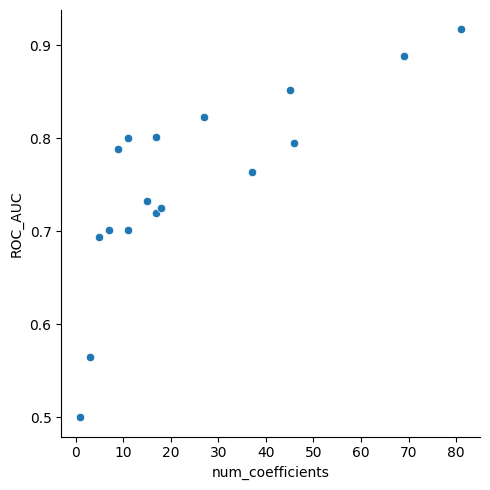

In [25]:
sns.relplot(data = model_results_df, x='num_coefficients', y='ROC_AUC')
plt.show()

As you can see, the plot isn't exactly the same, but it still has the same increasing pattern. By including so many features using polynomials and interactions in our model, we have generated more complex features, so there are 80 plus unknowns that directly help to improve the training set performance. Finally, let's visualize the entire ROC_AUC curve for each model. This is how we can confirm that we have identified the best complex model from our training set. For this, we will define a function that returns the complete ROC curve for each model.

In [26]:
# Define ROC Curve model viz function - NO threshold
def roc_model_viz( model_name, a_formula, training_data):
    fit_model = smf.logit( formula = a_formula, data = training_data).fit() # fit any model
    
    # Make a hard copy of the training set dataset
    training_set = training_data.copy() 
    
    # Calculate training set predictive probability
    training_set['pred_probability'] = fit_model.predict( training_data )
     
    # Get the FPR ( False Positive Rate), TPR (Tru Positive Rate) and threshold from ROC
    fpr, tpr, threshold = roc_curve( training_set.output.to_numpy(), training_set.pred_probability.to_numpy() ) 
    
    # Create a roc result dictionary as dataframe 
    roc_result_df = pd.DataFrame( {'tpr': tpr,
                         'fpr': fpr,
                         'threshold': threshold} )
    # Add model name and formula columns
    roc_result_df['model_name'] = model_name
    roc_result_df['model_formula'] = a_formula

    # Return the ROC datafrme
    return roc_result_df

In [27]:
# Now make a new roc model list and iterate over the model list 
roc_result_list = []

# Iterate over the model list 
for m in range(len(model_list)):
    roc_result_list.append(roc_model_viz( m, model_list[m], training_data = df))

Optimization terminated successfully.
         Current function value: 0.641035
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634259
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594506
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588229
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569593
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.587858
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.513238
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.503664
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.481047
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.499744
  

In [28]:
# Concatenate the ROC fitted list and assign it to the roc results df
roc_result_df = pd.concat(roc_result_list, ignore_index=True)

In [29]:
# View the ROC list dataframe info
roc_result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1594 entries, 0 to 1593
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tpr            1594 non-null   float64
 1   fpr            1594 non-null   float64
 2   threshold      1594 non-null   float64
 3   model_name     1594 non-null   int64  
 4   model_formula  1594 non-null   object 
dtypes: float64(3), int64(1), object(1)
memory usage: 62.4+ KB


Let's visualize the ROC curve for each model. Before we do this, notice that the model name column is an integer. Let's convert it to a categorical variable so we can distinguish the different models in the visualization.

In [30]:
# Convert model name column to category
roc_result_df['model_name'] = roc_result_df['model_name'].astype( 'category' )

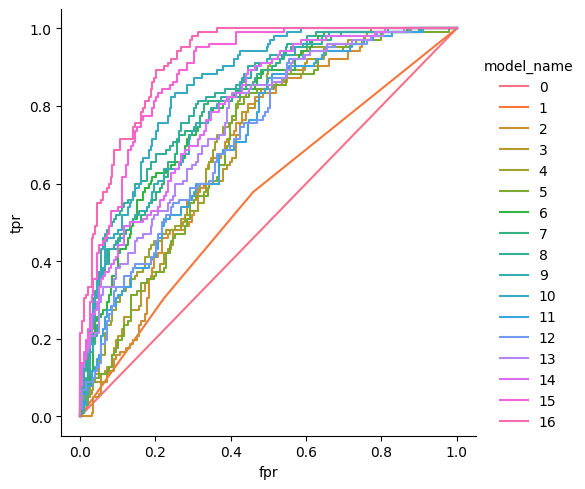

In [31]:
# Visualise ROC Curve
sns.relplot(data =  roc_result_df, x='fpr', y='tpr', hue='model_name',
           kind='line', estimator=None, units='model_name')
plt.show()

We can see that the ROC curve is pretty close. Let's use facets to expand the plots into five columns

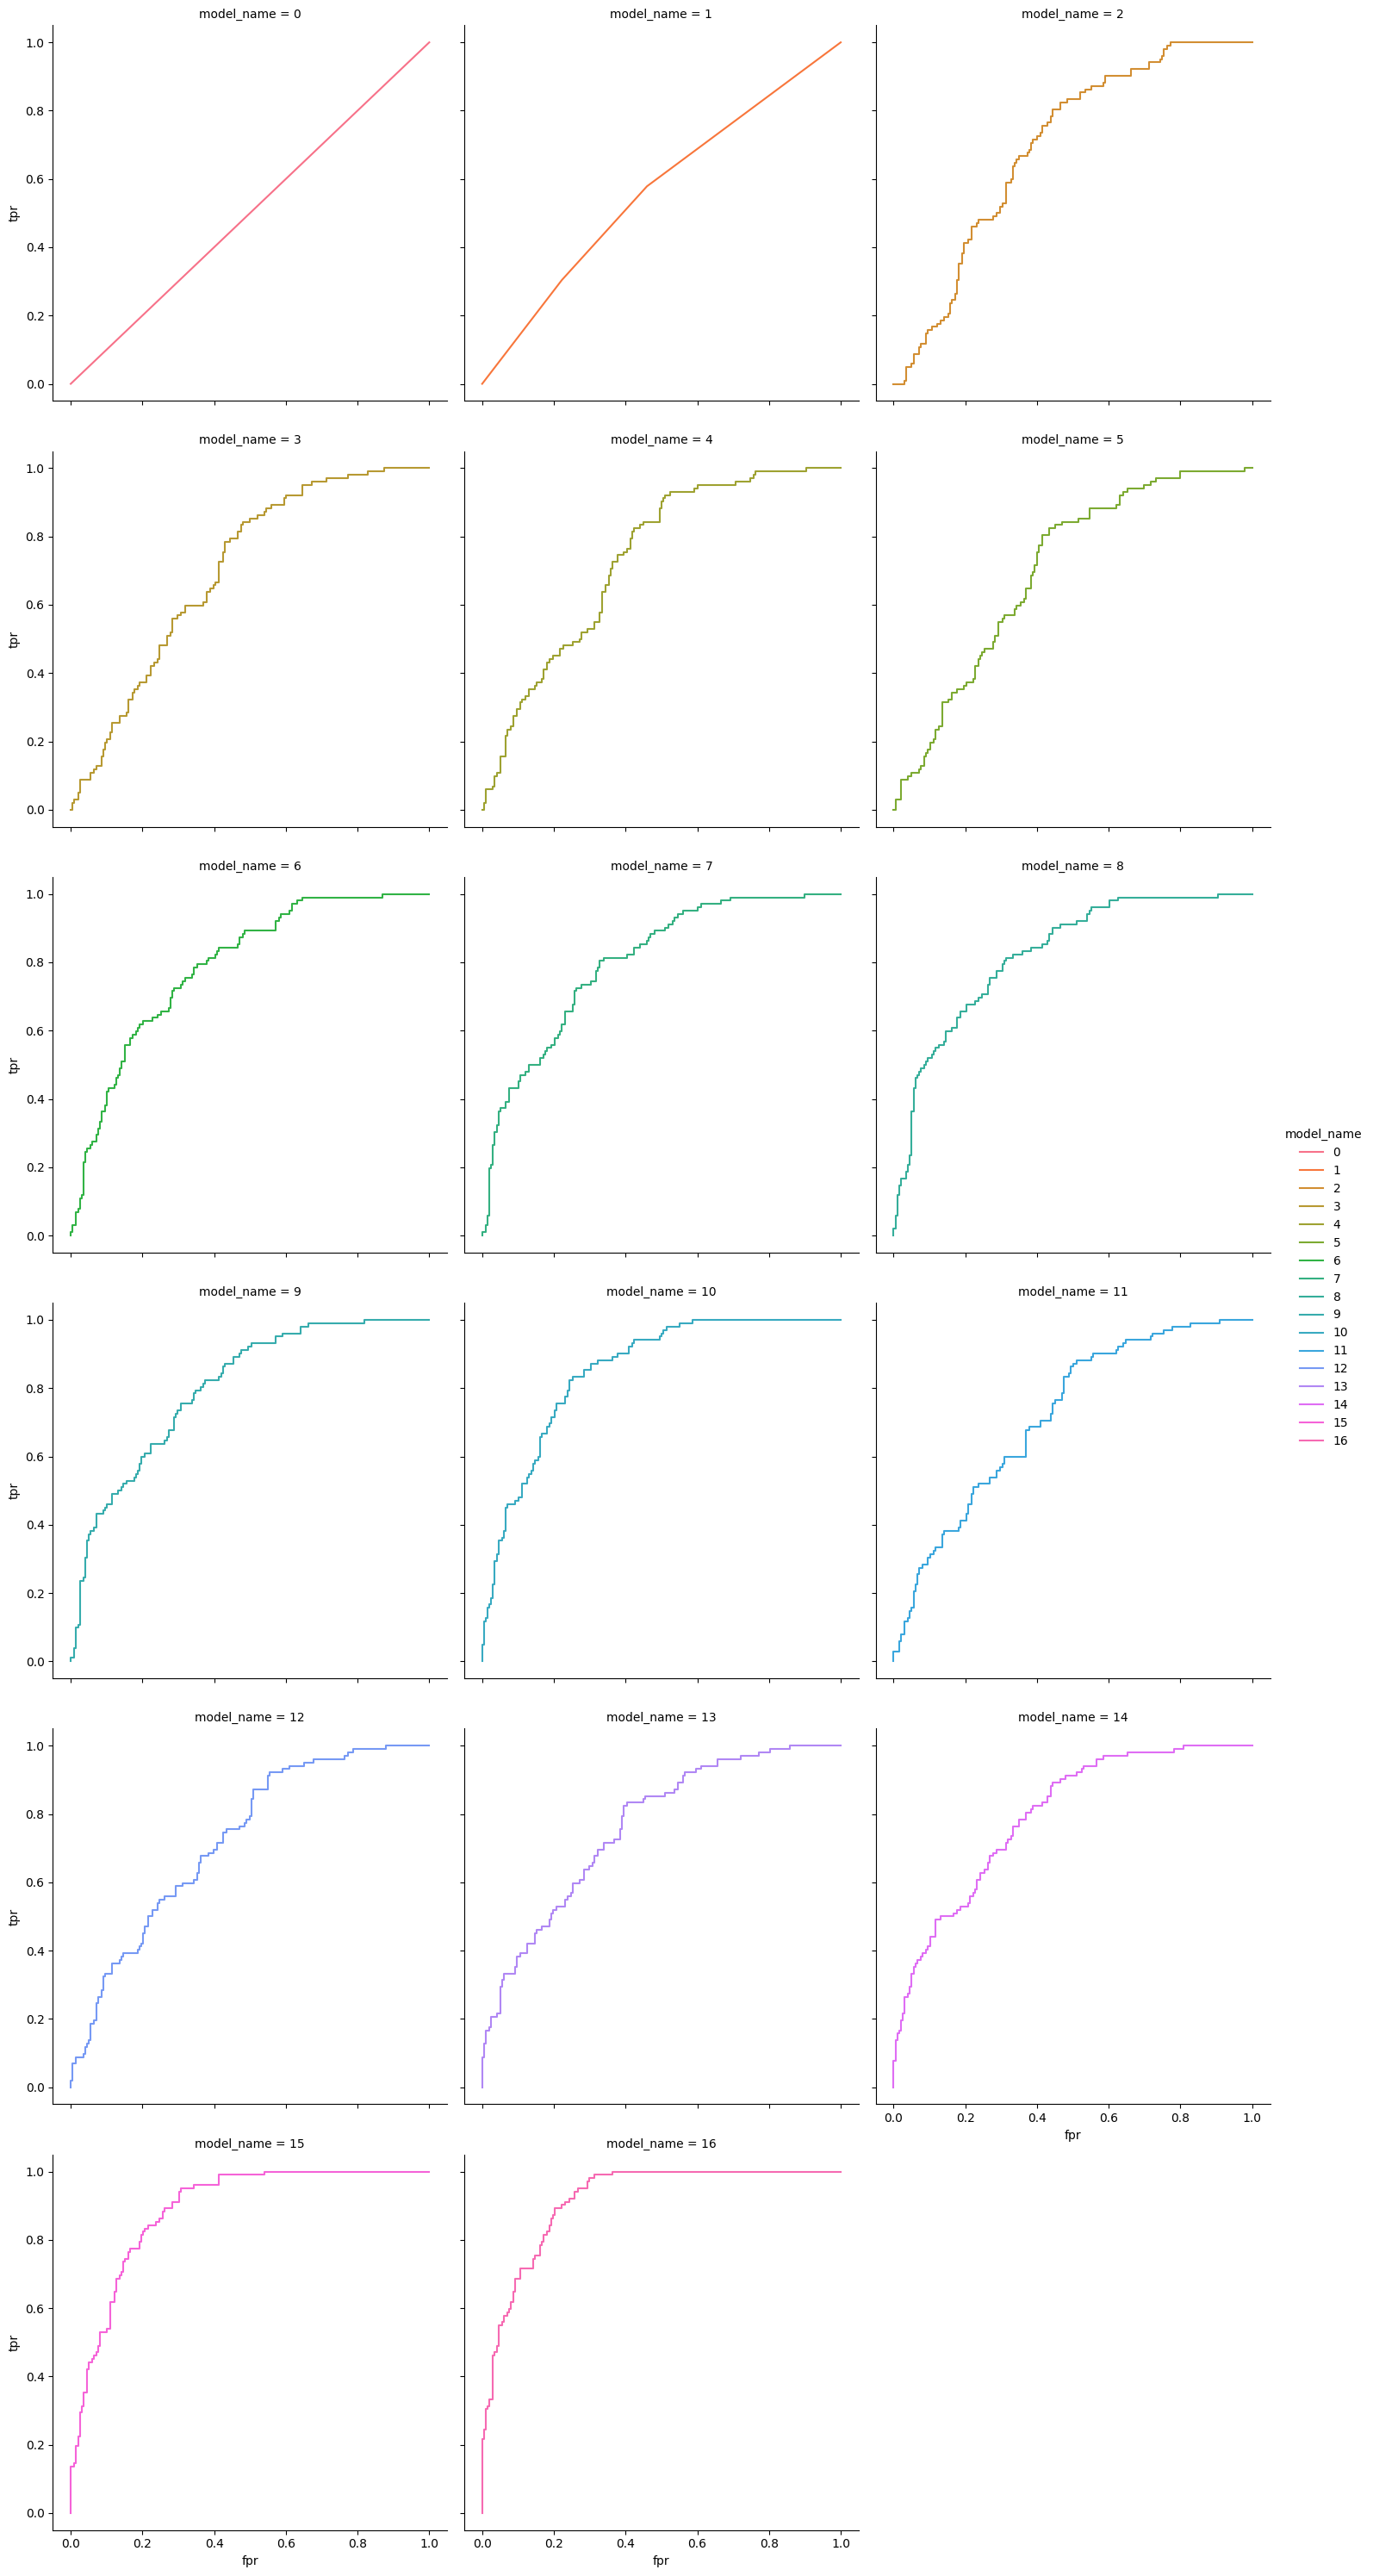

In [32]:
# Visualize the ROC curve to confirm the best-fit model is model number 16
sns.relplot(data = roc_result_df, x='fpr', y='tpr', hue='model_name',
           kind='line', estimator=None, units='model_name',
           col='model_name', col_wrap=3)
plt.show()

## Models Performance Summary
According to the training set, the best model is the data used to fit the models with the most unknown coefficients or slope estimates. It does seem that the more unknowns we introduce, the more accurate the model is.

## Finally, let Visulize Predictions 
Let's make a prediction grid to visualize the predicted event probability for different input combinations in our dataset. I will focus on the relationship between the event probability and `input_1` for different values of `input_2` and the categorical input.

In [33]:
# Preview our primary dataset
df.head()

,input_1,input_2,input_3,input_4,input_5,output
0,1.125708,0.318240,-0.562729,0.721059,b,0
1,0.038214,1.525541,-1.492170,-1.190414,b,0
2,-0.132998,-0.072113,1.505507,0.026712,b,1
3,1.928824,-0.976429,1.165456,1.522892,b,0
4,-0.386148,0.802894,-0.094305,-0.657699,b,0


In [34]:
# Create prediction input grid using 101 evenly space values for the features min and max and mean values
pred_grid = pd.DataFrame([ (input_1, input_2, input_3, input_4, input_5) for input_1 in np.linspace(df.input_1.min(), df.input_1.max(), num=101)
                                                 for input_2 in np.linspace(df.input_2.min(), df.input_2.max(), num=9)
                                                 for input_3 in [df.input_3.mean()]
                                                 for input_4 in [df.input_4.mean()]
                                                 for input_5 in df.input_5.unique() ],
                          columns=['input_1', 'input_2', 'input_3', 'input_4', 'input_5'])

In [35]:
# Create a df for visualizing the model prediction 
# Make a deep copy of the input grid training set
pred_df_viz = pred_grid.copy()

In [36]:
# Check the input grid training data for prediction
pred_df_viz.head()

,input_1,input_2,input_3,input_4,input_5
0,-2.913116,-3.008946,0.002302,0.001372,b
1,-2.913116,-3.008946,0.002302,0.001372,a
2,-2.913116,-3.008946,0.002302,0.001372,c
3,-2.913116,-2.242719,0.002302,0.001372,b
4,-2.913116,-2.242719,0.002302,0.001372,a


In [37]:
# Check the dimension
pred_df_viz.shape

(2727, 5)

In [38]:
# Check the number of unique values
pred_df_viz.nunique()

input_1    101
input_2      9
input_3      1
input_4      1
input_5      3
dtype: int64

Let's fit our best model using the model list

In [39]:
# select the most complex model
model_list[16]

'output ~ input_5 * ( (input_1 + input_2 + input_3 + input_4)**3 + np.power(input_1,2) + np.power(input_2,2) + np.power(input_3,2) + np.power(input_4,2) + np.power(input_1,3) + np.power(input_2,3) + np.power(input_3,3) + np.power(input_4,3) + np.power(input_1,4) + np.power(input_2,4) + np.power(input_3,4) + np.power(input_4,4) )'

In [40]:
# Fit the complet formula
best_model_fit = smf.logit(formula=model_list[16], data=df).fit()

Optimization terminated successfully.
         Current function value: 0.335107
         Iterations 12


In [41]:
# Check the estimates
best_model_fit.params

Intercept                            1.320581
input_5[T.b]                        -1.552826
input_5[T.c]                        -0.022902
input_1                             -0.998869
input_5[T.b]:input_1                 1.210213
                                       ...   
input_5[T.b]:np.power(input_3, 4)    0.416084
input_5[T.c]:np.power(input_3, 4)    0.224892
np.power(input_4, 4)                 0.284632
input_5[T.b]:np.power(input_4, 4)   -0.394857
input_5[T.c]:np.power(input_4, 4)   -1.348794
Length: 81, dtype: float64

In [42]:
# Check all the slopes that are estimated
best_model_fit.params.to_numpy()

array([ 1.32058095, -1.55282638, -0.02290171, -0.9988693 ,  1.2102127 ,
        4.66947597,  1.90020218, -2.80989522,  0.01302911,  2.48168371,
       -0.96904051, -3.70302173, -2.00940075,  2.05631202, -1.42985181,
       -1.96785309,  3.25014955, -2.70804585, -0.58525923,  0.05788615,
        2.25275043,  0.89524115, -1.68284148,  1.52848922, -1.14562035,
        2.31962476,  3.7961458 , -0.50683116,  0.46859127,  1.42882239,
        1.31683802, -1.20552019,  1.06433771, -0.34984964,  0.29108868,
       -5.68198569,  0.73811828, -0.97567907, -5.31258558,  0.51251628,
       -0.23690389, -1.06781236, -0.88103307,  0.95685953, -1.40207326,
        0.78548406,  0.32390322, -6.11743806, -0.39173843, -1.41806941,
        1.74981065, -2.08533623, -0.07217375, -0.85639912, -1.18932018,
        1.95855023,  7.7673739 ,  1.54691021, -0.69605481, -1.9847706 ,
       -4.90112106,  3.96307639,  3.21648377, -0.60610656,  0.63119099,
        0.994993  ,  0.4187507 , -0.44076032,  1.67639326, -1.16

In [43]:
# Add a predicted probability column 
pred_df_viz['pred_prob_best_model'] = best_model_fit.predict( pred_grid )

In [44]:
pred_df_viz

,input_1,input_2,input_3,input_4,input_5,pred_prob_best_model
0,-2.913116,-3.008946,0.002302,0.001372,b,2.001029e-30
1,-2.913116,-3.008946,0.002302,0.001372,a,1.564839e-68
2,-2.913116,-3.008946,0.002302,0.001372,c,5.223184e-56
3,-2.913116,-2.242719,0.002302,0.001372,b,6.848157e-32
4,-2.913116,-2.242719,0.002302,0.001372,a,1.195648e-53
...,...,...,...,...,...,...
2722,2.783826,2.354646,0.002302,0.001372,a,1.004841e-71
2723,2.783826,2.354646,0.002302,0.001372,c,2.727255e-45
2724,2.783826,3.120873,0.002302,0.001372,b,1.566123e-35
2725,2.783826,3.120873,0.002302,0.001372,a,3.526699e-162


### Visualize the best-fit model 
Visualize the relationship with respect to `input_5` and `input_2`

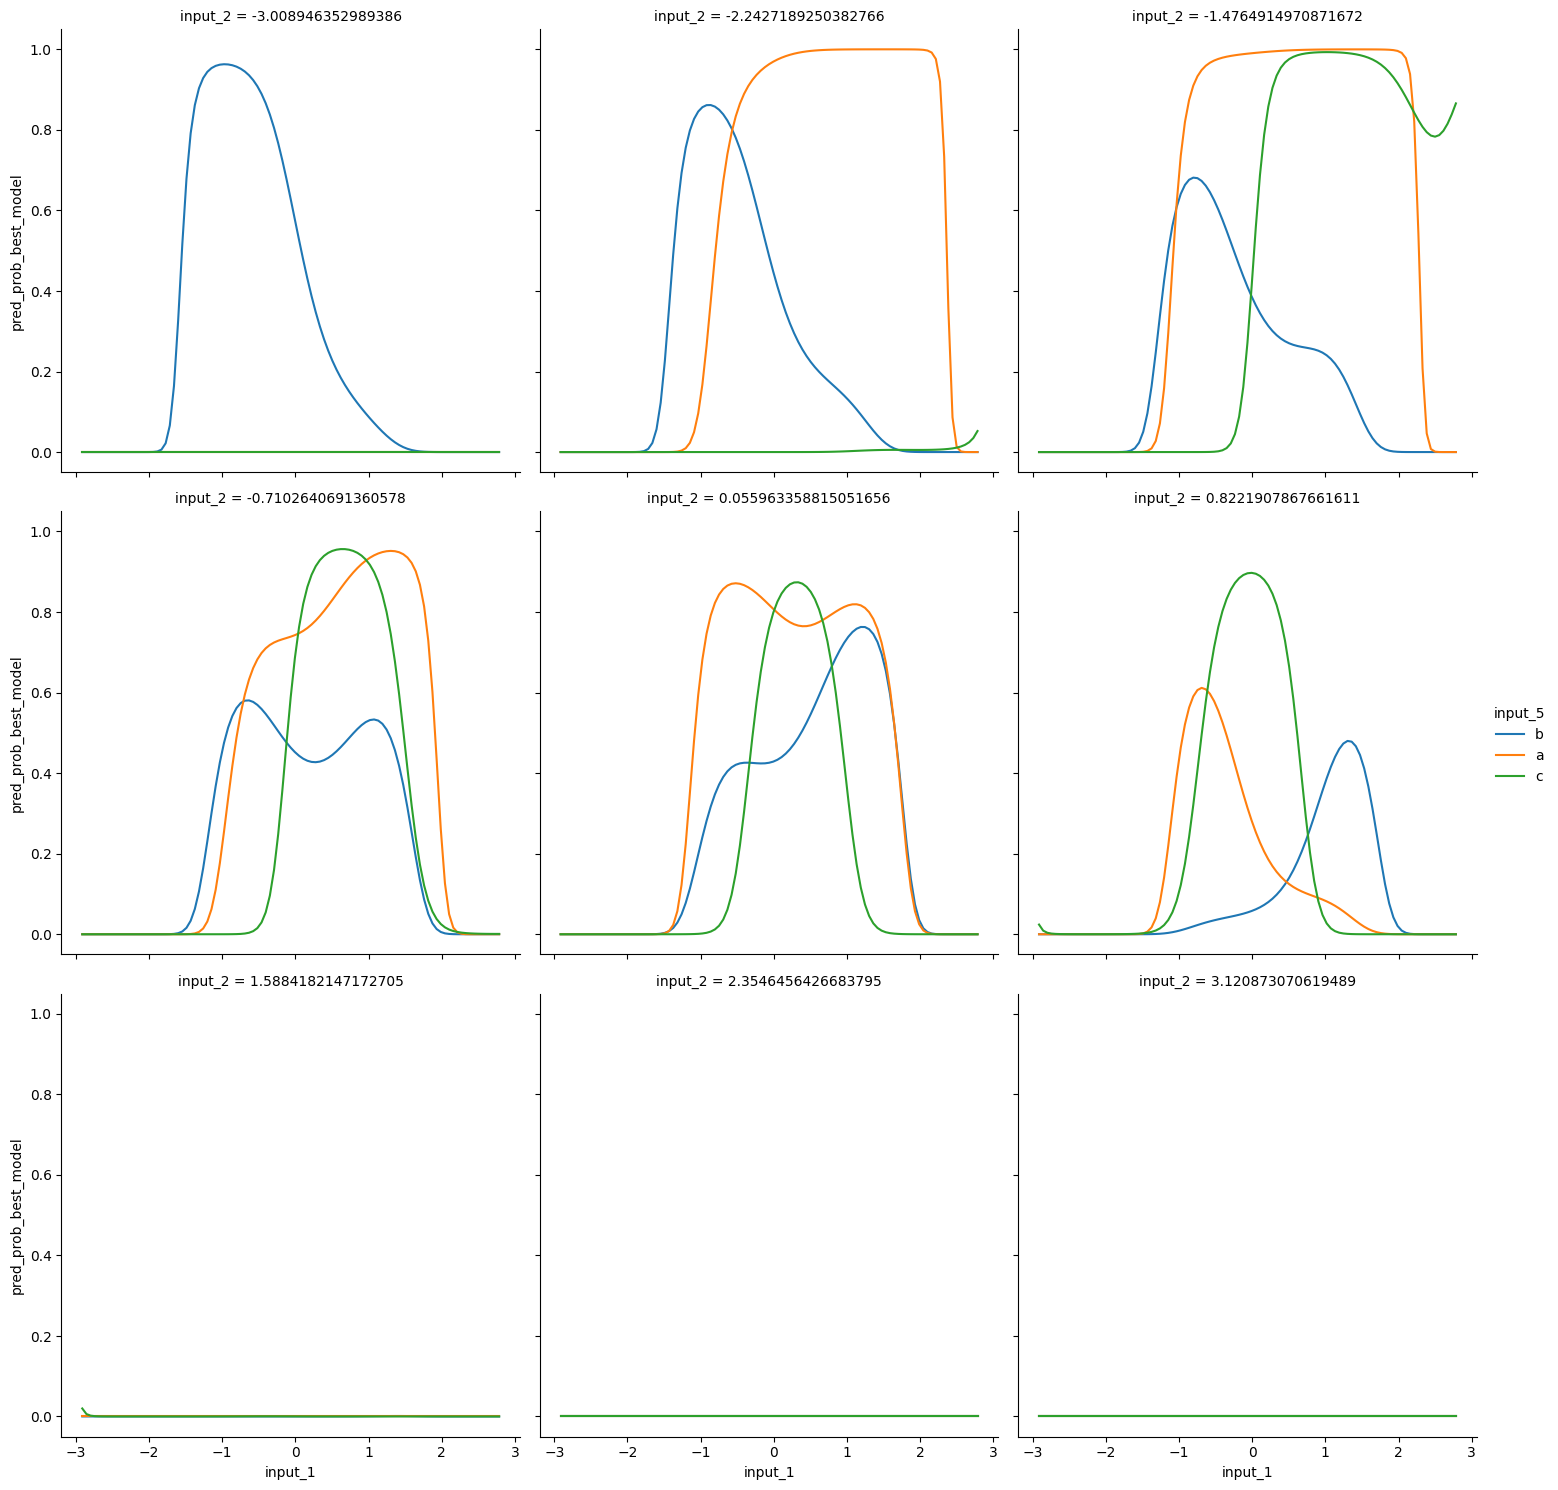

In [45]:
sns.relplot(data = pred_df_viz, x='input_1', y='pred_prob_best_model', hue='input_5',
           col='input_2', kind='line', estimator=None, units='input_5', col_wrap=3)
plt.show()

You can see that the probability of the event is the green line with respect to input_2. It starts at 0, increases rapidly, and flat lines near 1, then decreases rapidly as input_1 changes. However, depending on the value of input_2, that relationship with respect to input_5 value a will change. If you look at the green curve across the different facets, you will see that until input_2 becomes positive, the predictive probability will always be 0 with respect to input_1 and input_5. This confirms that model number 16 is still the best according to all of my training set matrics. Because as you can see it has the most numer of features, the most number of unknowns and capable of creating coplex visualization relationship and our preformance matrix says it is the best.

Overall I cannot conclude that it is the best until I test it on other tools. Please feel free to contribute to this case study. 